NLL data conversion script \ This script is for filtering the earthquake data and converting it into a suitable input format for FMTOMO.

In [1]:
# IMPORT PACKAGES

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', None)
import os
import glob
import re
import shutil
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
import matplotlib.pyplot as plt
import math


In [2]:
#-------------------------------------------------------------------------------------------------------------------
# OPTIONS
#-------------------------------------------------------------------------------------------------------------------

# give the dataset an identifier
dataset_name = "D7"
# if high-residual picks are to be removed post-inversion, provide name of the model
model_name = "reyk_final_model" 
#-------------------------------------------------------------------------------------------------------------------

# define model bounds
lat_max = 64.05
lat_min = 63.8
lon_max = 338.15
lon_min = 337.38
depth_min = 1
depth_max = 16
# exclude all events outside model bounds (should always be True)
event_bounds_filtering = True
# exclude all stations outside model bounds (should always be True)
station_bounds_filtering = True

#-------------------------------------------------------------------------------------------------------------------

# pre-filter data based on event quality statistics calculated by NonLinLoc
NLL_filtering = True
# choose whether to filter based on NLL RMS value (if True then choose a reasonably high value to begin with since the original data will contain duplicate picks etc)
NLL_RMS_filtering = True
NLL_RMS_max = 0.15
# choose whether to filter based on NLL maximum azimuthal gap (should always be set to True)
NLL_gap_filtering = True
NLL_max_gap = 180
# choose whether to filter based on NLL minimum number of arrivals per event (should always be set to True)
NLL_nphs_filtering = True
NLL_picks_min = 5
# choose whether to filter based on NLL minimum event-station distance (should always be set to True)
NLL_dist_filtering = True

#-------------------------------------------------------------------------------------------------------------------

# choose whether to filter events based on updated RMS value (noting that the recalculated values use residuals and weights with less decimal places from the event files - choose a reasonable value)
recalc_RMS_filtering = False
recalc_RMS_max = 0.15
# choose whether to filter events based on updated maximum azimuthal gap (should always be set to True)
recalc_gap_filtering = True
recalc_max_gap = 180
# choose whether to filter events based on updated minimum number of arrivals per event (should always be set to True)
recalc_nphs_filtering = True
recalc_picks_min = 5
# choose whether to filter events based on minimum number of stations
no_of_stations_filtering = True
stations_min = 5

#-------------------------------------------------------------------------------------------------------------------

# choose whether to set a minimum number of P-picks per event
P_nphs_filtering = False
P_picks_min = 5
# choose whether to remove events which have a max azimuthal gap greater than 180 degrees between P-arrivals (used when testing P only relocation)
calculate_max_gap_P = False

# choose whether to set a minimum number of S-picks per event
S_nphs_filtering = False
S_picks_min = 5

#-------------------------------------------------------------------------------------------------------------------

# if high-residual picks have been identified from a previous model run, choose whether to remove them from input data
remove_high_residual_picks = False

#-------------------------------------------------------------------------------------------------------------------

# choose whether to generate data histograms
make_figures = False

#-------------------------------------------------------------------------------------------------------------------

In [3]:
# DEFINE FILE AND DIRECTORY PATHS

data_directory = "/home/hra35/Documents/events" # parent data directory

path_to_stations = os.path.join(data_directory, "station_coordinates.txt") # path to the file containing station coordinates, from Tim

path_to_tim_picks = os.path.join(data_directory, "tim_picks") # directory to Tim's pick files
path_to_esme_picks = os.path.join(data_directory, "esme_picks") #  directory to Esme's pick files
path_to_hr_picks = os.path.join(data_directory, "hr_picks") #  directory to my pick files
path_to_all_picks = os.path.join(data_directory, "all_picks") # directory to all pick files combined

path_to_nll_script_outputs = os.path.join(data_directory, "nll_script_outputs") # parent destination directory for any output files by the data conversion script

path_to_model_nll_script_outputs = os.path.join(path_to_nll_script_outputs, "%s" %dataset_name) # model directory within the destination file output directory
if not os.path.exists(path_to_model_nll_script_outputs):
    os.makedirs(path_to_model_nll_script_outputs)

path_to_fmtomo_files = os.path.join(path_to_model_nll_script_outputs, "fmtomo_inputs") # path to directory where all generated FMTOMO input files will be saved
if not os.path.exists(path_to_fmtomo_files):
    os.makedirs(path_to_fmtomo_files)
    
path_to_residuals = os.path.join(data_directory, "residuals") # path to parent directory containing all residual calculation files
path_to_model_residuals = os.path.join(path_to_residuals, "%s" %model_name) # path to directory containing residual files for the relevant model
if not os.path.exists(path_to_model_residuals):
    os.makedirs(path_to_model_residuals)

path_to_high_residual_picks_P = os.path.join(path_to_model_residuals, "p_picks_rm.txt") # text file with high-residual P-picks to remove
path_to_high_residual_picks_S = os.path.join(path_to_model_residuals, "s_picks_rm.txt") # text file with high-residual S-picks to remove


In [4]:
# LIST ALL NLL PICK FILES

# make a list of Tim's nonlinloc output files
tim_nll_files = glob.glob(os.path.join(path_to_tim_picks, f'*{".hyp"}'))
print("Number of event files from Tim: ", len(tim_nll_files))

# make a list of Esme's nonlinloc output files
esme_nll_files = glob.glob(os.path.join(path_to_esme_picks, f'*{".hyp"}'))
print("Number of event files from Esme: ", len(esme_nll_files))

# make a list of my nonlinloc output files
hr_nll_files = glob.glob(os.path.join(path_to_hr_picks, f'*{".hyp"}'))
print("Number of event files from Hanna-Riia: ", len(hr_nll_files))

# copy all pick files to a shared folder, also removing obvious duplicates with the same name

# function to copy files, checking for duplicates
def copy(source_files, destination):
    for source_file in source_files:
        base_name = os.path.basename(source_file)
        destination_file = os.path.join(destination, base_name)
        if not os.path.exists(destination_file):
            shutil.copy(source_file, destination_file)

# copy Tim's files to the destination directory
copy(tim_nll_files, path_to_all_picks)

# copy Esme's files to the destination directory
copy(esme_nll_files, path_to_all_picks)

# copy my pick files to the destination directory
copy(hr_nll_files, path_to_all_picks)

# make a comprehensive list
all_nll_files = glob.glob(os.path.join(path_to_all_picks, f'*{".hyp"}'))

# check for empty files
for file in all_nll_files:
    if os.path.getsize(file) == 0:
        # delete the file if it's empty
        os.remove(file)
        #print(f"The file '{file}' was empty and has been deleted.")
    else:
        pass
    
# update the file list
all_nll_files = glob.glob(os.path.join(path_to_all_picks, f'*{".hyp"}'))
print("Total number of event files with unique identifiers: ", len(all_nll_files))

Number of event files from Tim:  2003
Number of event files from Esme:  196
Number of event files from Hanna-Riia:  30
Total number of event files with unique identifiers:  2215


In [5]:
# READ IN EVENT DATA

# make a copy of the full list (will be edited as events are removed)
nll_files = all_nll_files

# iterate through the files to get event id-s from filenames
event_id_list = []
for file in nll_files:
    event_id = os.path.splitext(os.path.basename(file))[0]
    event_id_list.append(event_id)
    
# initialise the event dataframe
event_df = pd.DataFrame(data=None, columns=["event_ID",
                                            "lat",
                                            "lon",
                                            "depth",
                                            "RMS",
                                            "Gap",
                                            "Dist",
                                            "Nphs",
                                            "Picker",
                                            "No_stations"])

event_df["event_ID"] = event_id_list
    
# read the event .hyp files and fill in the dataframe with coordinates and NLL statistics values
for file in nll_files:
    with open(file, 'r') as file_to_read:
        lines = file_to_read.readlines()
        for line in lines:
            
            if line.startswith("GEOGRAPHIC"):
                entries = line.split()
                latitude = entries[9]
                longitude = entries[11]
                depth = entries[13]

            if line.startswith("QUALITY"):
                entries = line.split()
                rms = entries[8]
                nphs = entries[10]
                gap = entries[12]
                dist = entries[14]
            
    file_name = os.path.splitext(os.path.basename(file))[0]
    event_df.loc[event_df["event_ID"] == file_name, ["lat", "lon", "depth", "RMS", "Gap", "Dist", "Nphs"]] = [latitude, longitude, depth, rms, gap, dist, nphs]
    
# convert dataframe entries to floats
numerical_columns = ['lat', 'lon', 'depth', 'RMS', "Gap", "Dist", "Nphs", "No_stations"]
for column in numerical_columns:
    event_df[column] = event_df[column].astype(float)
    event_df[column] = event_df[column].round(6)
    
# convert event longitudes to Eastward coordinates (for FMTOMO)
event_df['lon'] = event_df['lon'] + 360

# save the full unfiltered dataframe for later
full_event_df = event_df.copy()

#print(event_df)

In [6]:
# FILTER EVENTS BASED ON MODEL EXTENT

if event_bounds_filtering == True:
    
    # filter dataframe, removing all events outside model region
    filtered_df = event_df[(event_df['lon'] >= lon_min) & (event_df['lon'] <= lon_max) & (event_df['lat'] >= lat_min) & (event_df['lat'] <= lat_max) & (event_df['depth'] >= depth_min) & (event_df['depth'] <= depth_max)]
    event_df = filtered_df

    # update list of event files to read after applying filter    
    updated_file_list = []
    for file in nll_files:
        event = os.path.splitext(os.path.basename(file))[0]
        event_in_range = event in event_df['event_ID'].values
        if event_in_range == True:
            updated_file_list.append(file)
        else:
            pass
    nll_files = updated_file_list

print(len(nll_files))

2173


In [7]:
# FILTER EVENTS BASED ON NLL QUALITY STATISTICS

if NLL_filtering == True:

    # filter based on max azimuthal gap value from NLL
    
    if NLL_gap_filtering == True:
        
        # filter dataframe
        init = len(event_df)
        filtered_df = event_df[(event_df['Gap'] < NLL_max_gap)]
        event_df = filtered_df
        fin = len(event_df)
        removed = init - fin

        # update list of event files to read after applying filter    
        updated_file_list = []
        for file in nll_files:
            event = os.path.splitext(os.path.basename(file))[0]
            event_in_range = event in event_df['event_ID'].values
            if event_in_range == True:
                updated_file_list.append(file)
        nll_files = updated_file_list
        print("Number of events removed based on NLL max. azimuthal gap value: ", removed)
        
    # filter based on total number of picks per event from NLL

    if NLL_nphs_filtering == True:
    
        # filter dataframe
        init = len(event_df)
        filtered_df = event_df[(event_df["Nphs"] > NLL_picks_min)]
        event_df = filtered_df
        fin = len(event_df)
        removed = init - fin

        # update list of event files to read after applying filter    
        updated_file_list = []
        for file in nll_files:
            event = os.path.splitext(os.path.basename(file))[0]
            event_in_range = event in event_df['event_ID'].values
            if event_in_range == True:
                updated_file_list.append(file)
        nll_files = updated_file_list
        print("Number of events removed based on NLL number of picks: ", removed)
       
    # filter events based on minimum event-station distance 

    if NLL_dist_filtering == True:
    
        # filter dataframe, removing all events with minimum event-station distance greater than event depth
        init = len(event_df)
        dist_mask = (event_df["Dist"] > event_df["depth"])
        event_df = event_df[~dist_mask]
        fin = len(event_df)
        removed = init - fin
    
        # update list of event files to read after applying filter    
        updated_file_list = []
        for file in nll_files:
            event = os.path.splitext(os.path.basename(file))[0]
            event_in_range = event in event_df['event_ID'].values
            if event_in_range == True:
                updated_file_list.append(file)
        nll_files = updated_file_list
        print("Number of events removed based on NLL minimum event-station distance: ", removed)
        
    # filter based on RMS error from NLL
        
    if NLL_RMS_filtering == True:
    
        # filter dataframe
        init = len(event_df)
        filtered_df = event_df[(event_df['RMS'] <= NLL_RMS_max)]
        event_df = filtered_df
        fin = len(event_df)
        removed = init - fin

        # update list of event files to read after applying filter    
        updated_file_list = []
        for file in nll_files:
            event = os.path.splitext(os.path.basename(file))[0]
            event_in_range = event in event_df['event_ID'].values
            if event_in_range == True:
                updated_file_list.append(file)
        nll_files = updated_file_list

        print("Number of events removed based on NLL RMS error: ", removed)
    
    # write an updated event file after filtering based on NLL for GMT
    event_df.to_csv(os.path.join(path_to_model_nll_script_outputs, "nll_filtered_events.txt"), sep='\t', float_format='%.6f', index=False)
    
    print("Total number of events left after preliminary NLL quality filtering: ", len(event_df))
    

Number of events removed based on NLL max. azimuthal gap value:  377
Number of events removed based on NLL number of picks:  7
Number of events removed based on NLL minimum event-station distance:  123
Number of events removed based on NLL RMS error:  17
Total number of events left after preliminary NLL quality filtering:  1649


In [8]:
# READ IN STATIONS

# read the station file into a dataframe
station_df = pd.read_csv(path_to_stations, sep=r'\s+', names = ['stat_ID', 'rm1', 'lat', 'lon', 'elev_km', 'rm2'])
station_df.drop(['rm1', 'rm2'], axis=1, inplace=True)

# remove stations that occur twice 
duplicate_mask = station_df.duplicated(subset='stat_ID', keep='last')
station_df = station_df[~duplicate_mask]

# convert station longitudes to Eastward coordinates
station_df['lon'] = station_df['lon'] + 360

# make a list of all station IDs
station_id_list = station_df['stat_ID'].tolist()

print("Total number of stations in the network: ", len(station_df))

# remove stations not in model region
if station_bounds_filtering == True:
    
    # filter dataframe, removing all stations outside model region
    filtered_df = station_df[(station_df['lon'] >= lon_min) & (station_df['lon'] <= lon_max) & (station_df['lat'] >= lat_min) & (station_df['lat'] <= lat_max)]
    station_df = filtered_df
   
    # update station list  
    model_station_id_list = station_df['stat_ID'].tolist()
    
print("Number of stations in model region: ", len(model_station_id_list))

Total number of stations in the network:  54
Number of stations in model region:  48


In [9]:
# READ IN PICK DATA FOR EACH EVENT

# define the relevant keywords in the .hyp file
start_word = "PHASE"
end_word = "END_PHASE"

# initialize a flag to indicate when to start and stop recording lines
recording = False

# initialise dictionary to store extracted lines per event file
sta_data_dict = {}
dict_keys = []

for file in nll_files:
    
    Esme = False
    Tim = False
    HR = False
    
    #esme = "Esme"
    #tim = "Tim"
    #hr = "Hanna-Riia"
    
    # check whose pick file is being read
    with open(file, 'r') as file_to_read:
        content = file_to_read.read()
        if "Esme" in content:
            Esme = True
            name = "Esme"
        elif "Tim" in content:
            Tim = True
            name = "Tim"
        else:
            HR = True
            name = "Hanna-Riia"
                
    # list to store the extracted lines
    extracted_lines = []
    with open(file, 'r') as file_to_read:
        
        for line in file_to_read:
            # check if the line starts with the start_word
            if line.strip().startswith(start_word):
                recording = True
                continue  # skip the line with the start_word itself
            if recording == True:
                # check if the line starts with the end_word to stop recording
                if line.strip().startswith(end_word):
                    recording = False
                    continue  # skip the line with the end_word itself            
                # add the line to the list of extracted lines
                extracted_lines.append(line.strip())
                
                extracted_line_data = []
                for data_line in extracted_lines:
                    # split the line using the regex pattern (deals with any number of whitespaces between data values)
                    line_data = re.split(r'\s+', data_line)
                    extracted_line_data.append(line_data)                    
                
                # save the extracted line data into a dataframe per event, format depending on whose pick file it is
                if Tim == True or HR == True:
                    df = pd.DataFrame(extracted_line_data, columns=["stat_ID","Ins","Cmp","On","Phase","FM","Date","HrMn","Sec","Err","ErrMag","Coda","Amp","Per","PriorWt",">","TTpred","Res","Weight","StaLocX","StaLocY","StaLocZ","SDist","SAzim","RAz","RDip","RQual","Tcorr","TTerr"])
                    df.loc[:, 'event_ID'] = os.path.splitext(os.path.basename(file))[0]
                    df = df[["event_ID", "stat_ID","Ins","Cmp","On","Phase","FM","Date","HrMn","Sec","Err","ErrMag","Coda","Amp","Per","PriorWt",">","TTpred","Res","Weight","StaLocX","StaLocY","StaLocZ","SDist","SAzim","RAz","RDip","RQual","Tcorr","TTerr"]]
                if Esme == True:
                    df = pd.DataFrame(extracted_line_data, columns=["stat_ID","Ins","Cmp","On","Phase","FM","Date","HrMn","Sec","Err","ErrMag","Coda","Amp","Per",">","TTpred","Res","Weight","StaLocX","StaLocY","StaLocZ","SDist","SAzim","RAz","RDip","RQual","Tcorr"])
                    df.loc[:, 'event_ID'] = os.path.splitext(os.path.basename(file))[0]
                    df = df[["event_ID", "stat_ID","Ins","Cmp","On","Phase","FM","Date","HrMn","Sec","Err","ErrMag","Coda","Amp","Per",">","TTpred","Res","Weight","StaLocX","StaLocY","StaLocZ","SDist","SAzim","RAz","RDip","RQual","Tcorr"]]
                       
    # save the dataframe into a dictionary with an event ID based key            
    sta_data_dict["StaData_" + os.path.splitext(os.path.basename(file))[0]] = df
    
    # make a list of the keys
    key = ("StaData_" + os.path.splitext(os.path.basename(file))[0])
    dict_keys.append(key)
    
    # save the name of the picker
    condition = event_df["event_ID"] == os.path.splitext(os.path.basename(file))[0]
    event_df.loc[condition, "Picker"] = name

print("Number of event pick dataframes in dictionary is ", len(sta_data_dict))


Number of event pick dataframes in dictionary is  1649


In [10]:
# AT THIS STAGE, CHECK FOR (AND GET RID OF) DOUBLY PICKED EVENTS

# get a list of event IDs as integers
events = event_df["event_ID"]
events_int = [int(x) for x in events]
events = events_int

# identify events with similar origin times (difference of 5s)
likely_duplicate_pairs = []
for i in range(len(events)):
    for j in range(i+1, len(events)):
        if abs(events[i] - events[j]) < 5000:
            likely_duplicate_pairs.append((events[i], events[j]))

print("Number of event pairs with origin time difference of less than 5 s:", len(likely_duplicate_pairs))
#print(likely_duplicate_pairs)

# compare the station dataframes of likely duplicates

identical_pick_data = []
different_pick_data = []

for pair in likely_duplicate_pairs:
    
    # get event pick dataframes
    event1 = pair[0]
    event2 = pair[1]
    key1 = ("StaData_" + str(event1))
    key2 = ("StaData_" + str(event2))
    sta_data_1 = sta_data_dict[key1]
    sta_data_2 = sta_data_dict[key2]
    
    # sort in alphabetical order
    sta_data_1 = sta_data_1.sort_values(by='stat_ID',ascending=True)
    sta_data_1 = sta_data_1.reset_index(drop=True)
    sta_data_2 = sta_data_2.sort_values(by='stat_ID',ascending=True)
    sta_data_2 = sta_data_2.reset_index(drop=True)

    # compare pick dataframes
    if len(sta_data_1) == len(sta_data_2):
        
        # check if both dataframes have the same stations
        comparison_result = sta_data_1["stat_ID"].equals(sta_data_2["stat_ID"])
        
        if comparison_result:
            identical_pick_data.append(pair)
        else:
            different_pick_data.append(pair)
            
    else:
        different_pick_data.append(pair)
            
print("Number of identified duplicate event pairs: ", len(identical_pick_data))
#print(identical_pick_data)
#print("Number of events to check further: ", len(different_pick_data)) # checked manually, not duplicates

# get rid of one event per duplicate pair, keeping the one with lower NLL RMS uncertainty
duplicates_to_remove = []
for pair in identical_pick_data:
    
    event1 = str(pair[0])
    event2 = str(pair[1])
    
    RMS_1 = event_df.loc[(event_df["event_ID"] == event1), "RMS"].values[0]
    RMS_2 = event_df.loc[(event_df["event_ID"] == event2), "RMS"].values[0]
    
    if RMS_1 > RMS_2:
        duplicates_to_remove.append(event1)
        
    else:
        duplicates_to_remove.append(event2)

# filter dataframe
init = len(event_df)
mask = (event_df["event_ID"].isin(duplicates_to_remove))
event_df = event_df[~mask]
fin = len(event_df)
removed = init - fin

# update list of event files and list of dictionary keys after removing duplicates   
updated_file_list = []
keys = []
for file in nll_files:
    event = os.path.splitext(os.path.basename(file))[0]
    event_in_range = event in event_df['event_ID'].values
    if event_in_range == True:
        updated_file_list.append(file)
        keys.append(("StaData_" + str(event)))
nll_files = updated_file_list
dict_keys = keys

print("Total number of events after removing duplicates: ", len(event_df))

Number of event pairs with origin time difference of less than 5 s: 323
Number of identified duplicate event pairs:  323
Total number of events after removing duplicates:  1326


In [11]:
# EXTRA CLEANING STEPS TO REMOVE BAD PICKS AND ANY STATIONS OUTSIDE MODEL REGION

# faulty picks
inaccurate_picks = []
zero_tt = []
double_picked = []
timing_error = []

# loop through each event pick dataframe
for key in dict_keys:

    sta_data_original = sta_data_dict[key]
    sta_data = sta_data_original.copy()
    
    # if stations have been excluded from the model region, remove picks from these stations
    if (station_bounds_filtering == True) & (model_station_id_list != station_id_list):
        mask = (sta_data["stat_ID"].isin(model_station_id_list))
        sta_data = sta_data[mask]
        sta_data.reset_index(drop=True, inplace=True)
            

    # drop picks with a TT error of 10 000 (very tentatve picks)
    sta_data['ErrMag'] = sta_data['ErrMag'].astype(float)
    a = len(sta_data)
    sta_data = sta_data[sta_data['ErrMag'] <= 1]
    sta_data.reset_index(drop=True, inplace=True)
    b = len(sta_data)
    c = a-b
    if c != 0:
        inaccurate_picks.append(c)
        
    # drop picks with NLL residual >1s (will remove any outlier picks that still have timing errors, e.g. HELL, TKEL in 2021)
    sta_data['Res'] = sta_data['Res'].astype(float)
    a = len(sta_data)
    sta_data = sta_data[abs(sta_data['Res']) < 1]
    sta_data.reset_index(drop=True, inplace=True)
    b = len(sta_data)
    c = a-b
    if c != 0:
        timing_error.append(c)
    
    # drop picks with a TT of zero
    sta_data['TTpred'] = sta_data['TTpred'].astype(float)
    a = len(sta_data)
    sta_data.loc[sta_data['TTpred'] == 0, 'TTpred'] = np.nan
    sta_data = sta_data.dropna(subset=['TTpred'])
    b = len(sta_data)
    c = a-b
    if c != 0:
        zero_tt.append(c)
                
    # drop duplicate picks with same station and phase, keeping the pick with higher weight/lower residual
    sta_data = sta_data.sort_values(by=['Weight'], ascending=[True])
    a = len(sta_data)
    sta_data.drop_duplicates(subset=['stat_ID', 'Phase'], keep='last', inplace=True)
    sta_data.reset_index(drop=True, inplace=True)
    b = len(sta_data)
    c = a-b
    if c != 0:
        double_picked.append(c)       
        
    # save the new dataframe into dictionary
    if sta_data.empty == False:
        sta_data_dict[key] = sta_data
    else:
        print("Empty pick dataframe")
            
print("Total number of bad picks removed is ", (sum(inaccurate_picks) + sum(timing_error) + sum(zero_tt) + sum(double_picked)))


Total number of bad picks removed is  513


In [12]:
# MAKE A MASTER DATAFRAME OF ALL THE REMAINING PICKS

# create an empty list to hold all event pick dataframes
dfs = []

# loop through the dictionary keys
for key in dict_keys:
    sta_data = sta_data_dict[key]
    rows_to_append = sta_data[["event_ID", "stat_ID", "Phase", "TTpred", "ErrMag", "Res", "Weight"]]
    dfs.append(rows_to_append)

# concatenate all event dataframes in the list
all_picks_df = pd.concat(dfs, ignore_index=True)
all_picks_df.rename(columns={'TTpred': 'TT_obs', 'ErrMag': 'TT_err', 'Res': 'NLL_res'}, inplace=True)

# add event coordinates to the pick dataframe
all_picks_df = all_picks_df.merge(event_df[['event_ID', 'lat', 'lon', 'depth', 'Nphs']], on='event_ID', how='left')

# check for duplicate rows (shouldn't be an issue at this stage)
all_picks_df.drop_duplicates(inplace=True)

grouped_df = all_picks_df.groupby('event_ID')
print("Total number of events: ", len(grouped_df))
print("Total number of picks: ", len(all_picks_df))

# save into file
all_picks_df.to_csv(os.path.join(path_to_model_nll_script_outputs, "picks.txt"), sep='\t', float_format='%.6f', index=False)

# make an unfiltered copy
all_picks_df_full = all_picks_df.copy()

Total number of events:  1326
Total number of picks:  27741


In [13]:
# IF HIGH-RESIDUAL PICKS HAVE PREVIOUSLY BEEN IDENTIFIED, REMOVE THEM FROM INPUT DATA AT THIS POINT

if remove_high_residual_picks == True:
    
    grouped_df = all_picks_df.groupby('event_ID')
    print("Total number of events before removing high-residual picks: ", len(grouped_df))
    print("Total number of picks before removing high-residual picks: ", len(all_picks_df))
    
    # read in P picks to remove
    if os.path.exists(path_to_high_residual_picks_P):
        p_to_rm = pd.read_csv(path_to_high_residual_picks_P, delimiter='\t')
        p_to_rm = p_to_rm[['event_ID', 'station_ID']]
        print("Number of P-picks to remove:", len(p_to_rm))
        
        # remove high residual P-picks from main dataframe
        for index, row in p_to_rm.iterrows():
        
            event = str(row['event_ID'])
            station = str(row['station_ID'])

            p_mask = ((all_picks_df["event_ID"] == event) & (all_picks_df["stat_ID"] == station) & (all_picks_df["Phase"] == "P"))    
        
            all_picks_df = all_picks_df[~p_mask]
            all_picks_df.reset_index(drop=True, inplace=True)
    
    # read in S picks to remove
    if os.path.exists(path_to_high_residual_picks_S):
        s_to_rm = pd.read_csv(path_to_high_residual_picks_S, delimiter='\t')
        s_to_rm = s_to_rm[['event_ID', 'station_ID']]
        print("Number of S-picks to remove:", len(s_to_rm))
     
        # remove high residual S-picks from main dataframe
        for index, row in s_to_rm.iterrows():

            event = str(row['event_ID'])
            station_ID = str(row['station_ID'])
        
            s_mask = ((all_picks_df["event_ID"] == event) & (all_picks_df["stat_ID"] == station_ID) & (all_picks_df["Phase"] == "S"))    

            all_picks_df = all_picks_df[~s_mask]
            all_picks_df.reset_index(drop=True, inplace=True)

        
    grouped_df = all_picks_df.groupby('event_ID')
    print("Total number of events after removing high-residual picks: ", len(grouped_df))
    print("Total number of picks after removing high-residual P-picks and S-picks: ", len(all_picks_df))
    

In [14]:
# CHECK HOW MANY ARRIVALS IN TOTAL ARE LEFT PER EVENT AND FILTER

if recalc_nphs_filtering == True:

    df = all_picks_df
    grouped_df = df.groupby('event_ID')
    
    print("Total no of events before removing events with too few arrivals: ", len(grouped_df))  
    print("Total no of picks left after removing events with few arrivals: ", len(df))
    
    # check number of picks
    events_to_keep = []
    for group_name, group_data in grouped_df:
        pick_count = len(group_data)
        df.loc[df["event_ID"] == group_name, "Nphs"] = pick_count
        # update the number of arrivals in the event df
        event_df.loc[event_df["event_ID"] == group_name, "Nphs"] = pick_count
        if pick_count >= recalc_picks_min:
            events_to_keep.append(group_name)

    # filter out events with fewer than the set number of picks
    filtered_df = df[df['event_ID'].isin(events_to_keep)]
    
    all_picks_df = filtered_df
    upd_grouped_df = all_picks_df.groupby('event_ID')

print("Total no of events left after removing events with few arrivals: ", len(upd_grouped_df))  
print("Total no of picks left after removing events with few arrivals: ", len(all_picks_df))


Total no of events before removing events with too few arrivals:  1326
Total no of picks left after removing events with few arrivals:  27741
Total no of events left after removing events with few arrivals:  1326
Total no of picks left after removing events with few arrivals:  27741


In [15]:
# CHECK HOW MANY STATIONS ARE LEFT PER EVENT

if no_of_stations_filtering == True:
    
    df = all_picks_df
    
    # group by event_ID
    grouped_df = df.groupby('event_ID')
    print("Total no of events before removing events with too few stations: ", len(grouped_df))  
    print("Total no of picks left after removing events with few stations: ", len(df))

    # count the number of stations
    to_keep = []
    for group_name, group_data in grouped_df:
        station_count = group_data['stat_ID'].nunique()
        
        # add the number of stations to the event df
        isevent = event_df["event_ID"] == group_name
        event_df.loc[isevent, "No_stations"] = station_count
        
        if station_count >= stations_min:
            to_keep.append(str(group_name))
    
    filtered_df = df[df['event_ID'].isin(to_keep)]
    
    all_picks_df = filtered_df
    upd_grouped_df = all_picks_df.groupby('event_ID')
    
print("Total no of events left after removing events with few stations: ", len(upd_grouped_df))  
print("Total no of picks left after removing events with few stations: ", len(all_picks_df))


Total no of events before removing events with too few stations:  1326
Total no of picks left after removing events with few stations:  27741
Total no of events left after removing events with few stations:  1306
Total no of picks left after removing events with few stations:  27603


In [16]:
# CHECK HOW MANY P-ARRIVALS THERE ARE PER EVENT AND FILTER

if P_nphs_filtering == True:
    
    print("Total no of events before removing events with too few P-arrivals: ", len(all_picks_df.groupby("event_ID")))  
    print("Total no of picks left after removing events with few P-arrivals: ", len(all_picks_df))
    
    df = all_picks_df[all_picks_df["Phase"] == "P"]
    grouped_df = df.groupby('event_ID')
   
    # check number of P-picks
    picks_count = grouped_df.size()

    # filter out events with fewer than the set number of picks
    events_to_keep = picks_count[picks_count >= P_picks_min]
    filtered_df = all_picks_df[all_picks_df['event_ID'].isin(events_to_keep.index)]
    
    all_picks_df = filtered_df
    upd_grouped_df = all_picks_df.groupby('event_ID')
    
    print("Total no of events left after removing events with few P-arrivals: ", len(upd_grouped_df))  
    print("Total no of picks left after removing events with few P-arrivals: ", len(all_picks_df))
    

In [17]:
# CHECK HOW MANY S-ARRIVALS THERE ARE PER EVENT AND FILTER

if S_nphs_filtering == True:
    
    print("Total no of events before removing events with too few S-arrivals: ", len(all_picks_df.groupby("event_ID")))  
    print("Total no of picks left after removing events with few S-arrivals: ", len(all_picks_df))
    
    df = all_picks_df[all_picks_df["Phase"] == "S"]
    grouped_df = df.groupby('event_ID')
   
    # check number of P-picks
    picks_count = grouped_df.size()

    # filter out events with fewer than the set number of picks
    events_to_keep = picks_count[picks_count >= S_picks_min]
    filtered_df = all_picks_df[all_picks_df['event_ID'].isin(events_to_keep.index)]
    
    all_picks_df = filtered_df
    upd_grouped_df = all_picks_df.groupby('event_ID')
    
    print("Total no of events left after removing events with few S-arrivals: ", len(upd_grouped_df))  
    print("Total no of picks left after removing events with few S-arrivals: ", len(all_picks_df))
    

In [18]:
# CHECK HOW MANY EVENTS LEFT HAVE MAX AZIMUTHAL GAP BELOW 180 AND FILTER

if recalc_gap_filtering == True:
   
    # get some geopy functions to calulate azimuths 
    def calculate_azimuth(station_coords, epicenter_coords):
        lat1, lon1 = math.radians(station_coords[0]), math.radians(station_coords[1])
        lat2, lon2 = math.radians(epicenter_coords[0]), math.radians(epicenter_coords[1])
        delta_lon = lon2 - lon1
        x = math.sin(delta_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon))
        azimuth_rad = math.atan2(x, y)
        azimuth_deg = math.degrees(azimuth_rad)
        return (azimuth_deg + 360) % 360
    def calculate_azimuthal_gap(azimuths):
        azimuths.sort()
        gaps = [azimuths[i + 1] - azimuths[i] for i in range(len(azimuths) - 1)]
        gaps.append(360 + azimuths[0] - azimuths[-1])
        return max(gaps)
    
    df = all_picks_df
    grouped_df = df.groupby('event_ID')
    
    print("Total no of events before removing events with high azimuthal gap: ", len(grouped_df))  
    print("Total no of picks left after removing events with high azimuthal gap: ", len(df))
    
    # function to calculate max gap for each group (event)
    def calculate_max_gap(group):
                
        azimuths = []
        event = str(group.name)
        evlat = full_event_df.loc[full_event_df["event_ID"] == event, "lat"].values[0]
        evlon = full_event_df.loc[full_event_df["event_ID"] == event, "lon"].values[0]
        event_coords = [evlat, evlon]
    
        for station in group["stat_ID"]:
            
            stalat = station_df.loc[station_df["stat_ID"] == station, "lat"].values[0]
            stalon = station_df.loc[station_df["stat_ID"] == station, "lon"].values[0]
            stat_coords = [stalat, stalon]
        
            azimuth = calculate_azimuth(stat_coords, event_coords)
            azimuths.append(azimuth)
    
        max_gap = calculate_azimuthal_gap(azimuths)
        return max_gap
    
    if calculate_max_gap_P == True:
        
        df = all_picks_df[all_picks_df["Phase"] == "P"]
        grouped_df = df.groupby('event_ID')
        
        # apply the function to each group to calculate the max_gap
        max_gap_series = grouped_df.apply(calculate_max_gap)

        # add the max_gap values to the pick df
        df["max_gap"] = df["event_ID"].map(max_gap_series)

        # filter out groups with max_gap higher than 180
        filtered_df = df[df["max_gap"] <= recalc_max_gap]
        
        # retrieve S-data
        all_picks_df = all_picks_df[all_picks_df["event_ID"].isin(filtered_df["event_ID"])]
        upd_grouped_df = all_picks_df.groupby('event_ID')
        
        print("Total no of events left after removing high P-arrival azimuthal gap events: ", len(upd_grouped_df))
        print("Total no of picks left after removing high P-arrival azimuthal gap events: ", len(all_picks_df))
        
    else:
        
        # apply the function to each group to calculate the max_gap
        max_gap_series = grouped_df.apply(calculate_max_gap)

        # add the max_gap values to the pick df
        df["max_gap"] = df["event_ID"].map(max_gap_series)

        # filter out groups with max_gap higher than 180
        filtered_df = df[df["max_gap"] <= recalc_max_gap]

        all_picks_df = filtered_df
        upd_grouped_df = all_picks_df.groupby('event_ID')

        print("Total no of events left after removing high azimuthal gap events: ", len(upd_grouped_df))
        print("Total no of picks left after removing high azimuthal gap events: ", len(all_picks_df))


Total no of events before removing events with high azimuthal gap:  1306
Total no of picks left after removing events with high azimuthal gap:  27603
Total no of events left after removing high azimuthal gap events:  1302
Total no of picks left after removing high azimuthal gap events:  27518


In [19]:
# CHECK HOW MANY EVENTS LEFT HAVE RMS UNCERTAINTY BELOW THRESHOLD AND FILTER

if recalc_RMS_filtering == True:
    
    # function to calulate weighted RMS error
    def weighted_rms_error(residuals, weights):
        residuals = np.array(residuals, dtype=np.float64)
        weights = np.array(weights, dtype=np.float64)
        squared_errors = np.square(residuals)
        weighted_squared_errors = np.multiply(weights, squared_errors)
        weighted_rms = np.sqrt(np.sum(weighted_squared_errors) / np.sum(weights))
        return weighted_rms
    
    # function to calculate the RMS for each event from the remaining picks
    def calc_rms(group):
        
        event = str(group.name)
        
        # get event pick data from dictionary
        key = ("StaData_" + event)        
        sta_data = sta_data_dict[key]
        
        # apply a mask to this dataframe, excluding picks which are not in the updated all_picks_df
        sta_phase_comb = set(zip(group['stat_ID'], group['Phase']))
        mask = sta_data.apply(lambda row: (row['stat_ID'], row['Phase']) in sta_phase_comb, axis=1)
        sta_data_filtered = sta_data[mask]
        
        diff = len(sta_data) - len(sta_data_filtered)
        if diff != 0:
            print("No of picks removed is ", diff, " for event ", event)
        
        # initialise lists to store residuals and weights
        residuals = []
        weights = []
        
        # get pick residuals and weights
        for index, row in sta_data_filtered.iterrows():
            
            # get pick residuals and weights
            pick_residual = row.loc["Res"]
            pick_weight = row.loc["Weight"]
            
            residuals.append(pick_residual)
            weights.append(pick_weight)
            
        # calculate the new RMS error for the event
        rms = weighted_rms_error(residuals, weights)
        return rms
    
    # group dataframe by event
    df = all_picks_df
    grouped_df = df.groupby('event_ID')
    
    print("Total no of events before removing events with high RMS error: ", len(grouped_df))  
    print("Total no of picks before removing events with high RMS error: ", len(df))
    
    # apply the function to each group to calculate the new rms error
    rms_series = grouped_df.apply(calc_rms)

    # add the rms values to the pick df
    df["new_rms"] = df["event_ID"].map(rms_series)
    
    # filter out groups with rms higher than specified value
    filtered_df = df[df["new_rms"] < recalc_RMS_max]

    # drop the rms column
    #filtered_df = filtered_df.drop(columns=["rms"])

    all_picks_df = filtered_df
    upd_grouped_df = all_picks_df.groupby('event_ID')

    print("Total no of events left after removing high RMS events: ", len(upd_grouped_df))
    print("Total no of picks left after removing high RMS events: ", len(all_picks_df))

no_P_picks = len(all_picks_df[all_picks_df["Phase"] == "P"])
no_S_picks = len(all_picks_df[all_picks_df["Phase"] == "S"])

print("No of P-picks: ", no_P_picks)
print("No of S-picks: ", no_S_picks)

#print(all_picks_df)

No of P-picks:  14165
No of S-picks:  13353


In [20]:
# SAVE ALL FINAL PICKS AND EVENTS

# save picks to file
all_picks_df.to_csv(os.path.join(path_to_model_nll_script_outputs, "picks_final.txt"), sep='\t', float_format='%.6f', index=False)

# save events to file
final_event_list = []
for event in event_df["event_ID"]:
    final_event = event in all_picks_df['event_ID'].values
    if final_event == True:
        final_event_list.append(event)
        gap = all_picks_df.loc[all_picks_df["event_ID"] == event, "max_gap"].values[0]
        event_df.loc[event_df["event_ID"] == event, "Gap"] = gap
        
mask = (event_df["event_ID"].isin(final_event_list))
event_df = event_df[mask]
event_df.reset_index(drop=True, inplace=True)

event_df.to_csv(os.path.join(path_to_model_nll_script_outputs, "events_final.txt"), sep='\t', float_format='%.6f', index=False)

print("Final number of events: ", len(final_event_list))

Final number of events:  1302


In [21]:
# DELETE ANY PREEXISTING PICK FILES FROM THE FMTOMO INPUTS FOLDER

files = os.listdir(path_to_fmtomo_files)
if files:
    for file in files:
        file_path = os.path.join(path_to_fmtomo_files, file)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
else:
    print("Pick file directory is empty.")

In [22]:
# WRITE P-PICK FILES PER STATION

# group the pick dataframe by event_ID
grouped_pick_df = all_picks_df.groupby('event_ID')

# initialise dictionary to store the order of events in the list
p_station_events = {}

# generate pick files

P_stations = []
for station_id in model_station_id_list:
    
    station_file_path = os.path.join(path_to_fmtomo_files, '%s.P' %station_id)
    pick_df = pd.DataFrame(columns=["lat", "lon", "depth", "traveltime", "traveltime_err"])
    pick_list = []
    
    for group_name, group_data in grouped_pick_df:
        
        # if the station recorded that event, get traveltime and traveltime error for P arrival from the dictionary
        mask = (group_data['stat_ID'] == station_id) & (group_data['Phase'] == 'P')
        
        if mask.any():
            
            # get traveltime data
            traveltime = group_data.loc[mask, 'TT_obs'].values[0]
            traveltime_err = group_data.loc[mask, 'TT_err'].values[0]
                       
            # get event coordinates
            lat = group_data.loc[mask, 'lat'].values[0]
            lon = group_data.loc[mask, 'lon'].values[0]
            depth = group_data.loc[mask, 'depth'].values[0]
                
            data_row = {"lat": lat, "lon": lon, "depth": depth, "traveltime": traveltime, "traveltime_err": traveltime_err}
            pick_df = pick_df.append(data_row, ignore_index=True)
            
            # add event_ID to list
            pick_list.append(group_name)
            
        else:
            pass
    
    # save the pick dataframe into a station pick file (if relevant phase picks exist for that station)
    if pick_df.shape[0] != 0:
        
        pick_df.to_csv(station_file_path, sep=' ', index=False, header=False)
    
        # calculate number of events and add it to the beginning of the pick file as required by FMTOMO_extras
        num_data_rows = len(pick_df)
        with open(station_file_path, 'r') as file:
            content = file.read()
        with open(station_file_path, 'w') as file:
            file.write(f"{num_data_rows}\n")
            file.write(content)
            
        # add the station pick file name to list
        P_stations.append(station_id)
        
        # save the list of events for this station
        key = f"{station_id}"
        p_station_events[key] = pick_list
        
    else:
        pass
    
print(len(P_stations))
#print(P_stations)

47


In [23]:
# WRITE S-PICK FILES PER STATION

# group the pick dataframe by event_ID
grouped_pick_df = all_picks_df.groupby('event_ID')

# initialise dictionary to store the order of events in the list
s_station_events = {}

# generate pick files
S_stations = []

for station_id in model_station_id_list:
    
    station_file_path = os.path.join(path_to_fmtomo_files, '%s.S' %station_id)
    pick_df = pd.DataFrame(columns=["lat", "lon", "depth", "traveltime", "traveltime_err"])
    pick_list = []
    
    for group_name, group_data in grouped_pick_df:
               
        # if the station recorded that event, get traveltime and traveltime error for S arrival from the dictionary
        mask = (group_data['stat_ID'] == station_id) & (group_data['Phase'] == 'S')
        
        if mask.any():
            # get traveltime data
            traveltime = group_data.loc[mask, 'TT_obs'].values[0]
            traveltime_err = group_data.loc[mask, 'TT_err'].values[0]
                       
            # get event coordinates
            lat = group_data.loc[mask, 'lat'].values[0]
            lon = group_data.loc[mask, 'lon'].values[0]
            depth = group_data.loc[mask, 'depth'].values[0]
                
            data_row = {"lat": lat, "lon": lon, "depth": depth, "traveltime": traveltime, "traveltime_err": traveltime_err}
            pick_df = pick_df.append(data_row, ignore_index=True)
            
            # add event_ID to list
            pick_list.append(group_name)
            
        else:
            pass
    
    # save the pick dataframe into a station pick file (if relevant phase picks exist for that station)
    if pick_df.shape[0] != 0:
        pick_df.to_csv(station_file_path, sep=' ', index=False, header=False)
    
        # calculate number of events and add it to the beginning of the pick file as required by FMTOMO_extras
        num_data_rows = len(pick_df)
        with open(station_file_path, 'r') as file:
            content = file.read()
        with open(station_file_path, 'w') as file:
            file.write(f"{num_data_rows}\n")
            file.write(content)
            
        # add the station pick file name to list
        S_stations.append(station_id)
        
        # save the list of events for this station
        key = f"{station_id}"
        s_station_events[key] = pick_list
        
    else:
        pass

print(len(S_stations))
#print(S_stations)

46


In [24]:
# rearrange the P and S station lists so that each shared station would have the same index
#(or the Vp/Vs inversion will not work!)

common_stations = list(set(P_stations).intersection(set(S_stations)))
print(len(common_stations))

P_rearr = common_stations[:]
S_rearr = common_stations[:]

for P_station in P_stations:
    if P_station not in P_rearr:
        P_rearr.append(P_station)

for S_station in S_stations:
    if S_station not in S_rearr:
        S_rearr.append(S_station)
        
S_stations = S_rearr
P_stations = P_rearr

print(len(S_stations))
print(len(P_stations))

46
46
47


In [25]:
# WRITE sourceslocal_P.in FILE FOR P-INVERSION

P_pick_files = glob.glob(os.path.join(path_to_fmtomo_files, f'*{".P"}'))
num_P_stations = len(P_pick_files)

# reorder the files
P_file_path_dict = {os.path.basename(file_path).split('.')[0]: file_path for file_path in P_pick_files}
sorted_P_pick_files = [P_file_path_dict[station] for station in P_stations]
P_pick_files = sorted_P_pick_files

with open(os.path.join(path_to_fmtomo_files, "sourceslocal_P.in"), 'w') as file:
    file.write(f"{num_P_stations}\n")
    
for file in P_pick_files:
    station_ID = os.path.splitext(os.path.basename(file))[0]
    station_row = station_df[station_df.iloc[:, 0] == station_ID]
    counter = (P_pick_files.index(file) + 1)
    
    with open(os.path.join(path_to_fmtomo_files, "sourceslocal_P.in"), 'a') as file_to_write:
        file_to_write.write(" ".join(map(str, station_row.iloc[:, [1, 2, 3]].values.flatten())))
        file_to_write.write(" ")
        file_to_write.write(str(counter))
        file_to_write.write("\n")
        file_to_write.write("1\n")
        file_to_write.write("1 1 ")
        file_to_write.write(os.path.basename(file))
        file_to_write.write("\n")                

In [26]:
# WRITE sourceslocal_S.in FILE FOR S-INVERSION

S_pick_files = glob.glob(os.path.join(path_to_fmtomo_files, f'*{".S"}'))
num_S_stations = len(S_pick_files)

# reorder the files
S_file_path_dict = {os.path.basename(file_path).split('.')[0]: file_path for file_path in S_pick_files}
sorted_S_pick_files = [S_file_path_dict[station] for station in S_stations]
S_pick_files = sorted_S_pick_files

with open(os.path.join(path_to_fmtomo_files, "sourceslocal_S.in"), 'w') as file:
    file.write(f"{num_S_stations}\n")
    
for file in S_pick_files:
    station_ID = os.path.splitext(os.path.basename(file))[0]
    station_row = station_df[station_df.iloc[:, 0] == station_ID]
    counter = (S_pick_files.index(file) + 1)
        
    with open(os.path.join(path_to_fmtomo_files, "sourceslocal_S.in"), 'a') as file_to_write:
        file_to_write.write(" ".join(map(str, station_row.iloc[:, [1, 2, 3]].values.flatten())))
        file_to_write.write(" ")
        file_to_write.write(str(counter))
        file_to_write.write("\n")
        file_to_write.write("1\n")
        file_to_write.write("1 1 ")
        file_to_write.write(os.path.basename(file))
        file_to_write.write("\n")

In [27]:
# LINK EVENT AND STATION ID-S TO FMTOMO ID-S TO GET RESIDUALS LATER (P-DATA)

# save station IDs to dataframe

p_stat_df = pd.DataFrame(data=None, columns=["stat_no", "stat_ID"])
p_stat_df["stat_no"] = np.arange(1, (num_P_stations+1))

# read sourceslocal_P file to get the station order

with open(os.path.join(path_to_fmtomo_files, "sourceslocal_P.in"), 'r') as file:
    station_lines = file.readlines()

for station in p_stat_df['stat_no']:
    
    station_line = station_lines[station*3]
    entries = station_line.split()
    station_file = entries[2]
    station_id = station_file.split('.')[0]
    
    p_stat_df.loc[p_stat_df['stat_no'] == station, 'stat_ID'] = station_id

#print(p_stat_df)

# generate dataframe with all event IDs and FMTOMO IDs matched

p_pick_df = pd.DataFrame(data=None, columns=["event_no", "event_ID"])
p_pick_df["event_no"] = np.arange(1, (no_P_picks+1))

all_events = []

for stat_id in p_stat_df["stat_ID"]:
    
    stat_events = p_station_events[stat_id]
    #print(len(stat_events))
    all_events.extend(stat_events)
        
p_pick_df["event_ID"] = all_events

# save to file
p_pick_df.to_csv(os.path.join(path_to_model_nll_script_outputs, "event_id_p.txt"), sep='\t', index=False)

#print(p_pick_df)

In [28]:
# LINK EVENT AND STATION ID-S TO FMTOMO ID-S TO GET RESIDUALS LATER (S-DATA)

# save station IDs to dataframe

s_stat_df = pd.DataFrame(data=None, columns=["stat_no", "stat_ID"])
s_stat_df["stat_no"] = np.arange(1, (num_S_stations+1))

# read sourceslocal_S file to get the station order

with open(os.path.join(path_to_fmtomo_files, "sourceslocal_S.in"), 'r') as file:
    station_lines = file.readlines()

for station in s_stat_df['stat_no']:
    
    station_line = station_lines[station*3]
    entries = station_line.split()
    station_file = entries[2]
    station_id = station_file.split('.')[0]
    
    s_stat_df.loc[s_stat_df['stat_no'] == station, 'stat_ID'] = station_id

# generate dataframe with all event IDs, station IDs and FMTOMO IDs matched

s_pick_df = pd.DataFrame(data=None, columns=["event_no", "event_ID"])
s_pick_df["event_no"] = np.arange(1, (no_S_picks+1))

all_events = []

for stat_id in s_stat_df["stat_ID"]:
    
    stat_events = s_station_events[stat_id]
    all_events.extend(stat_events)
        
s_pick_df["event_ID"] = all_events

# save to file
s_pick_df.to_csv(os.path.join(path_to_model_nll_script_outputs, "event_id_s.txt"), sep='\t', index=False)

#print(s_pick_df)

In [29]:
full_event_df['lon'] = full_event_df['lon'] - 360
event_df['lon'] = event_df['lon'] - 360

In [30]:
# OUTPUT EVENT FILES FOR PLOTTING IN GMT

full_event_df["depth"] = full_event_df["depth"] * -1
#print(full_event_df)
# full event catalogue
full_event_df.to_csv(os.path.join(path_to_nll_script_outputs, "all_events.txt"), sep='\t', float_format='%.6f', index=False)
full_event_df[['event_ID']].to_csv(os.path.join(path_to_nll_script_outputs, "all_event_IDs.txt"), sep='\t', float_format='%.6f', header=False, index=False)
# GMT-friendly file
full_event_df[['lon', 'lat']].to_csv(os.path.join(path_to_nll_script_outputs, "all_events_GMT.xy"), sep='\t', float_format='%.6f', header=False, index=False)
#print(full_event_df)
event_df["depth"] = event_df["depth"] * -1
#print(event_df)
# events to enter inversion
event_df.to_csv(os.path.join(path_to_model_nll_script_outputs, "filtered_events.txt"), sep='\t', float_format='%.6f', index=False)

# GMT-friendly file (including pick authors for plotting (0-Tim, 1-Esme, 2-HR))

if_esme = event_df['Picker'] == 'Esme'
if_tim = event_df['Picker'] == 'Tim'
if_hr = event_df['Picker'] == 'Hanna-Riia'

event_df.loc[if_esme, 'Picker'] = 0
event_df.loc[if_tim, 'Picker'] = 1
event_df.loc[if_hr, 'Picker'] = 2

event_df[['lon', 'lat', 'depth', 'Picker']].to_csv(os.path.join(path_to_model_nll_script_outputs, "filtered_events_GMT.xy"), sep='\t', float_format='%.6f', header=False, index=False)


# filter dataframe to only include the deep cluster
deep_df = event_df[(event_df['depth'] <= -7)]
deep_df[['lon', 'lat', 'depth']].to_csv(os.path.join(path_to_model_nll_script_outputs, "deep_events_GMT.xy"), sep='\t', float_format='%.6f', header=False, index=False)

shallow_df = event_df[(event_df['depth'] >= -7)]
shallow_df[['lon', 'lat', 'depth']].to_csv(os.path.join(path_to_model_nll_script_outputs, "shallow_events_GMT.xy"), sep='\t', float_format='%.6f', header=False, index=False)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


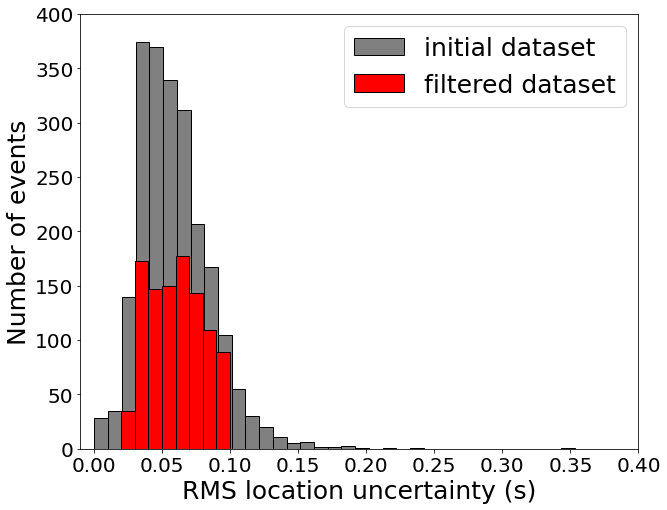

In [31]:
# PLOT EVENT QUALITY STATISTICS FROM NONLINLOC

full_event_df = pd.read_csv("/home/hra35/Documents/events/nll_script_outputs/all_events.txt", sep=r'\s+', skiprows=1, names = ["event_ID", "lat", "lon", "depth", "RMS", "Gap", "Dist", "Nphs", "Picker", "No_stations"])
final_event_df = pd.read_csv("/home/hra35/Documents/events/nll_script_outputs/D7_1D/events_final.txt", sep=r'\s+', skiprows=1, names = ["event_ID", "lat", "lon", "depth", "RMS", "Gap", "Dist", "Nphs", "Picker", "No_stations"])

# plot RMS histogram

plt.rcParams['font.family'] = 'Arial'

bin_width = 0.01

data_min_1 = np.min(full_event_df['RMS'])
data_max_1 = np.max(full_event_df['RMS'])
num_bins_1 = int((data_max_1 - data_min_1) / bin_width)

data_min_2 = np.min(final_event_df['RMS'])
data_max_2 = np.max(final_event_df['RMS'])
num_bins_2 = int((data_max_2 - data_min_2) / bin_width)

plt.figure(figsize=(10,8))

full_rms_histogram = plt.hist(full_event_df['RMS'], num_bins_1, color='grey', edgecolor='k', alpha=1, label='initial dataset')
filtered_rms_histogram = plt.hist(final_event_df['RMS'], num_bins_2, color='red', edgecolor='k', alpha=1, label='filtered dataset')
    
#plt.title('RMS histogram')
plt.xlabel('RMS location uncertainty (s)', fontsize=25)
plt.ylabel('Number of events', fontsize=25)
plt.ylim(0, 400)
plt.xlim(-0.010, 0.4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)

plt.savefig("/raid4/hra35/gmt_figures/report/rms_histogram.png")

plt.show()

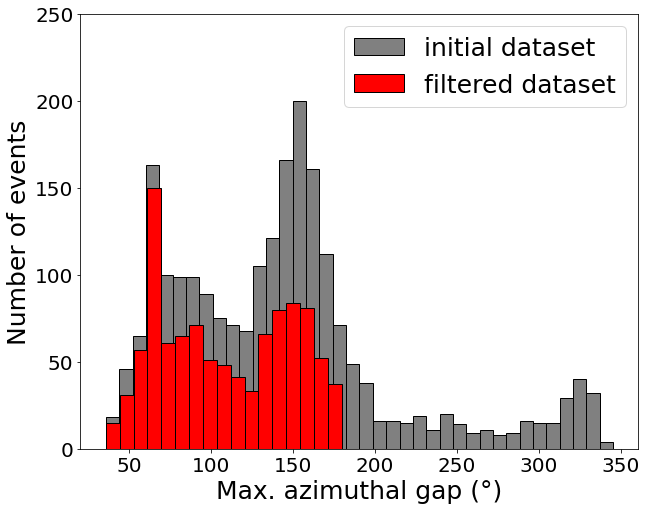

In [32]:
plt.rcParams['font.family'] = 'Arial'

# plot Gap histogram

bin_width = 8

data_min_1 = np.min(full_event_df['Gap'])
data_max_1 = np.max(full_event_df['Gap'])
num_bins_1 = int((data_max_1 - data_min_1) / bin_width)

data_min_2 = np.min(final_event_df['Gap'])
data_max_2 = np.max(final_event_df['Gap'])
num_bins_2 = int((data_max_2 - data_min_2) / bin_width)

plt.figure(figsize=(10,8))

gap_histogram = plt.hist(full_event_df['Gap'], num_bins_1, color='grey', edgecolor='k', alpha=1, label='initial dataset')
filtered_gap_histogram = plt.hist(final_event_df['Gap'], num_bins_2, color='red', edgecolor='k', alpha=1, label='filtered dataset')
    
#plt.title('RMS histogram')
plt.xlabel('Max. azimuthal gap (\N{DEGREE SIGN})', fontsize=25)
plt.ylabel('Number of events', fontsize=25)
plt.ylim(0, 250)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)

plt.savefig("/raid4/hra35/gmt_figures/report/gap_histogram.png")

plt.show()

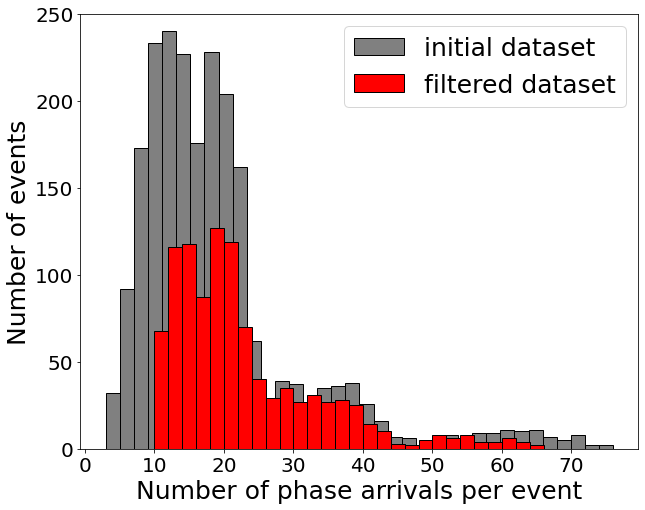

In [33]:
plt.rcParams['font.family'] = 'Arial'

# plot Nphs histogram

bin_width = 2

data_min_1 = np.min(full_event_df['Nphs'])
data_max_1 = np.max(full_event_df['Nphs'])
num_bins_1 = int((data_max_1 - data_min_1) / bin_width)

data_min_2 = np.min(final_event_df['Nphs'])
data_max_2 = np.max(final_event_df['Nphs'])
num_bins_2 = int((data_max_2 - data_min_2) / bin_width)

plt.figure(figsize=(10,8))

gap_histogram = plt.hist(full_event_df['Nphs'], num_bins_1, color='grey', edgecolor='k', alpha=1, label='initial dataset')
filtered_gap_histogram = plt.hist(final_event_df['Nphs'], num_bins_2, color='red', edgecolor='k', alpha=1, label='filtered dataset')
    
#plt.title('RMS histogram')
plt.xlabel('Number of phase arrivals per event', fontsize=25)
plt.ylabel('Number of events', fontsize=25)
plt.ylim(0, 250)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)

plt.savefig("/raid4/hra35/gmt_figures/report/nphs_histogram.png")

plt.show()

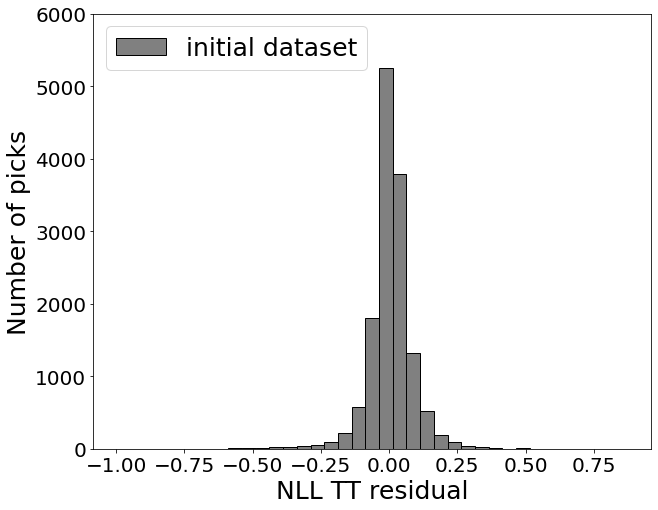

86.72872088979331
161.01861365129582


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

all_picks_df = pd.read_csv("/home/hra35/Documents/events/nll_script_outputs/D7/picks_final.txt", sep=r'\s+', header=0)
df = all_picks_df

p_df = df[df["Phase"] == "P"]
s_df = df[df["Phase"] == "S"]

# plot histograms

df = p_df

bin_width = 0.05

data_min_1 = np.min(df['NLL_res'])
data_max_1 = np.max(df['NLL_res'])
num_bins_1 = int((data_max_1 - data_min_1) / bin_width)

plt.figure(figsize=(10,8))

p_histogram = plt.hist(df['NLL_res'], num_bins_1, color='grey', edgecolor='k', alpha=1, label='initial dataset')
    
#plt.title('RMS histogram')
plt.xlabel('NLL TT residual', fontsize=25)
plt.ylabel('Number of picks', fontsize=25)
plt.ylim(0, 6000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)

plt.show()

def calc_rms(residuals):
    residuals = np.array(residuals, dtype=np.float64)
    squared_errors = np.square(residuals)
    rms = np.sqrt(np.sum(squared_errors) / len(residuals))
    return rms

rms = 1000 * calc_rms(df['NLL_res'])
print(rms)

df = s_df

rms = 1000 * calc_rms(df['NLL_res'])
print(rms)